# Test Functions for Kriging

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, arange
rng = np.random.RandomState(1)
X = linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
training_indices = rng.choice(arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
S = Kriging(name='kriging', seed=124)
S.fit(X_train, y_train)
mean_prediction, std_prediction, s_ei = S.predict(X, return_val="all")
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
    )
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")
plt.show()

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, arange
rng = np.random.RandomState(1)
X = linspace(start=0, stop=10, num=1_0).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
training_indices = rng.choice(arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
S = Kriging(name='kriging', seed=124)
S.fit(X_train, y_train)
mean_prediction, std_prediction, s_ei = S.predict(X, return_val="all")
# Kriging is a interpolator, so the mean prediction should be equal to the training points:
# check if the difference between the mean prediction and the true value in the training points is smaller than 1e-6
assert np.allclose(mean_prediction[training_indices], y[training_indices], atol=1e-6)


## Expected Improvement

In [ ]:
from spotPython.build.kriging import Kriging
from math import erf
import numpy as np
S = Kriging(name='kriging', seed=124)
S.aggregated_mean_y = [0.0, 0.0, 0.0, 0.0, 0.0]
# asset that the S.exp_imp(1.0, 0.0) is equal to 0.0
assert 0.0 == S.exp_imp(1.0, 0.0)
# assert that the S.exp_imp(0.0, 1.0) is equal to 1/sqrt(2 pi)
# assert S.exp_imp(0.0, 1.0) == 1/np.sqrt(2*np.pi)
# play safe and use np.allclose
assert np.allclose(S.exp_imp(0.0, 1.0), 1/np.sqrt(2*np.pi), atol=1e-6)
assert np.allclose(S.exp_imp(1.0, 1.0), -(0.5 + 0.5*erf(-1/np.sqrt(2))) + 1/np.sqrt(2*np.pi)*np.exp(-1/2), atol=1e-6)

# set_de_bounds

In [ ]:
from spotPython.build.kriging import Kriging
S = Kriging(name='kriging', seed=124)
S.set_de_bounds()
assert S.de_bounds == [[-3, 2]]
from spotPython.build.kriging import Kriging
n = 10
S = Kriging(name='kriging', seed=124, n_theta=n)
S.set_de_bounds()
assert len(S.de_bounds) == n
n=2
p=4
S = Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True)
S.set_de_bounds()
assert len(S.de_bounds) == n+p
S = Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=False)
S.set_de_bounds()
assert len(S.de_bounds) == n

## extract_from_bounds

In [ ]:
import numpy as np
from spotPython.build.kriging import Kriging
n=2
p=2
S = Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.extract_from_bounds(np.array([1, 2, 3]))
assert len(S.theta) == n

## optimize_model

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
assert len(new_theta_p_Lambda) == n+p+1
# no noise, so Lambda is not considered
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
assert len(new_theta_p_Lambda) == n+p

## update_log

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
S.update_log()
print(S.log)
assert len(S.log["negLnLike"]) == 1
assert len(S.log["theta"]) == n
assert len(S.log["p"]) == p
assert len(S.log["Lambda"]) == 1
S.update_log()
print(S.log)
assert len(S.log["negLnLike"]) == 2
assert len(S.log["theta"]) == 2*n
assert len(S.log["p"]) == 2*p
assert len(S.log["Lambda"]) == 2

## fit

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[.1, 0], [0, .1]])
nat_y = np.array([1, 2])
S = Kriging()
S.fit(nat_X, nat_y)
assert S.Psi.shape == (2, 2)
assert len(S.log["negLnLike"]) == 1
print(S.Psi)

## initialize_variables

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
S = Kriging()
S.initialize_variables(nat_X, nat_y)
assert S.nat_X.all() == nat_X.all()
assert S.nat_y.all() == nat_y.all()
assert S.nat_X.shape == (2, 2)
assert S.nat_y.shape == (2,)

## set_variable_types

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
assert S.var_type == ['num', 'num']
assert S.num_mask.all() == True
assert S.factor_mask.all() == False
assert S.int_mask.all() == False
assert S.ordered_mask.all() == True
S.num_mask

In [ ]:


nat_X = np.array([[1, 2, 3], [4, 5, 6]])
nat_y = np.array([1, 2])
n=3
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.var_type
assert S.var_type == ['num', 'num', 'num']

## set_theta_values

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
from numpy import array
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
n=2
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
assert S.theta.all() == array([0., 0.]).all()
nat_X = np.array([[1, 2], [3, 4]])
nat_y = np.array([1, 2])
# n is set to 3, but the number of columns of nat_X is 2
n=3
p=2
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
snt = S.n_theta
S.set_theta_values()
# since snt == 3, it is not equal to S.n_theta, which is 2 because 
# of the correction in the set_theta_values method
assert S.n_theta != snt


## initialize_matrices

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
from numpy import log, var
nat_X = np.array([[1, 2], [3, 4], [5, 6]])
nat_y = np.array([1, 2, 3])
n=3
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
# if var(self.nat_y) is > 0, then self.pen_val = self.n * log(var(self.nat_y)) + 1e4
# else self.pen_val = self.n * var(self.nat_y) + 1e4
assert S.pen_val == nat_X.shape[0] * log(var(S.nat_y)) + 1e4
assert S.Psi.shape == (n, n)
#
# use a zero variance, then the penalty should be computed without log()
nat_y = np.array([1, 1, 1])
n=3
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
# if var(self.nat_y) is > 0, then self.pen_val = self.n * log(var(self.nat_y)) + 1e4
# else self.pen_val = self.n * var(self.nat_y) + 1e4
assert S.pen_val == nat_X.shape[0] * (var(S.nat_y)) + 1e4
assert S.Psi.shape == (n, n)


## fun_likelihood

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[0], [1]])
nat_y = np.array([0, 1])
n=1
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
print(S.nat_X)
print(S.nat_y)
S.set_theta_values()
print(f"S.theta: {S.theta}")
S.initialize_matrices()
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
S.extract_from_bounds(new_theta_p_Lambda)
print(f"S.theta: {S.theta}")
S.build_Psi()
print(f"S.Psi: {S.Psi}")
S.build_U()
print(f"S.U:{S.U}")
S.likelihood()
# assert S.negLnLike < 0
S.negLnLike

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[0,1], [1, 0]])
nat_y = np.array([0, 10])
n=2
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
print(S.nat_X)
print(S.nat_y)
S.set_theta_values()
print(f"S.theta: {S.theta}")
S.initialize_matrices()
print(f"S.mu: {S.mu}")
S.set_de_bounds()
new_theta_p_Lambda = S.optimize_model()
print(f"S.mu: {S.mu}")
S.extract_from_bounds(new_theta_p_Lambda)
print(f"S.theta: {S.theta}")
S.build_Psi()
print(f"S.Psi: {S.Psi}")
S.build_U()
print(f"S.U:{S.U}")
print(f"S.mu: {S.mu}")
S.likelihood()
print(f"S.mu: {S.mu}")
# assert S.negLnLike < 0
S.negLnLike

## Kriging Example 1D

In [ ]:
from spotPython.build.kriging import Kriging
import numpy as np
nat_X = np.array([[1], [2]])
nat_y = np.array([5, 10])
n=2
p=1
S=Kriging(name='kriging', seed=124, n_theta=n, n_p=p, optim_p=True, noise=False, theta_init_zero=True)
S.initialize_variables(nat_X, nat_y)
S.set_variable_types()
S.set_theta_values()
S.initialize_matrices()
S.build_Psi()
S.build_U()
S.likelihood()
# assert S.mu is close to 7.5 with a tolerance of 1e-6
assert np.allclose(S.mu, 7.5, atol=1e-6)
E = np.exp(1)
sigma2 = E/(E**2 -1) * (25/4 + 25/4*E)
# asssert S.SigmaSqr is close to sigma2 with a tolerance of 1e-6
assert np.allclose(S.SigmaSqr, sigma2, atol=1e-6)


## Test spot initialize_design()

In [ ]:
import numpy as np
from math import inf
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
# number of initial points:
ni = 3
# additional start point
X_start = np.array([[10, 10]])
# number of points
n = 10

fun = analytical().fun_sphere
lower = np.array([1, 1])
upper = np.array([10, 100])
design_control={"init_size": ni}

spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            fun_evals = n,
            show_progress=True,
            design_control=design_control,)
spot_1.initialize_design(X_start=X_start)
spot_1.X

## test build_psi_vec()

In [ ]:
import numpy as np
from spotPython.build.kriging import Kriging

X_train = np.array([[1., 2.],
                    [2., 4.],
                    [3., 6.]])
y_train = np.array([1., 2., 3.])

S = Kriging(name='kriging',
            seed=123,
            log_level=50,
            n_theta=1,
            noise=False,
            cod_type="norm")
S.fit(X_train, y_train)

# force theta to simple values:
S.theta = np.array([0.0])
nat_X = np.array([1., 0.])
S.psi = np.zeros((S.n, 1))
S.build_psi_vec(nat_X)
res = np.array([[np.exp(-4)],
    [np.exp(-17)],
    [np.exp(-40)]])

# assert np.array_equal(S.psi, res)

S.psi, res


## spot: test update_ranges():

In [ ]:
import numpy as np
from math import inf
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
# number of initial points:
ni = 2
# additional start point
X_start = np.array([[10, 10]])
# number of points
n = 10

fun = analytical().fun_sphere
lower = np.array([1, 1])
upper = np.array([10, 100])
design_control={"init_size": ni}

spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            fun_evals = n,
            show_progress=True,
            var_type=['int', 'int'],
            design_control=design_control,)
spot_1.initialize_design(X_start=X_start)
spot_1. update_stats()
print(f"spot_1.X: {spot_1.X}")
print(f"spot_1.lower: {spot_1.lower}")
print(f"spot_1.upper: {spot_1.upper}")
# spot_1.X has entries like:
# [
#  [10, 10]
#  [ 7, 97]
#  [ 5, 41]
# ]
# spot_1.range_X has entries like:
# [
#  [ 5, 10] # min values for all dimensions (lower)
#  [10, 97] # max values for all dimensions (upper)
# ]
# check if the first entries in spot_1.X values are in the interval spot_1.range_X[0]
assert np.all(spot_1.X[:, 0] >= spot_1.lower[0])
assert np.all(spot_1.X[:, 0] <= spot_1.upper[0])
# check if the second entries in spot_1.X values are in the interval spot_1.range_X[1]
assert np.all(spot_1.X[:, 1] >= spot_1.lower[1])
assert np.all(spot_1.X[:, 1] <= spot_1.upper[1])

# test spot plot()

In [ ]:
import numpy as np
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
# number of initial points:
ni = 5
# additional start point
X_start = np.array([10])
# number of points
n = 7

fun = analytical().fun_sphere
lower = np.array([-1])
upper = np.array([10])
design_control={"init_size": ni}

spot_1 = spot.Spot(fun=fun,
            lower = lower,
            upper= upper,
            cod_type="norm",
            fun_evals = n,
            show_progress=True,
            var_type=['num'],
            design_control=design_control,)
spot_1.run()
np.min([np.min(spot_1.y), np.min(spot_1.y)])
#spot_1.plot_model(y_min=0, y_max=100)
#spot_1.get_spot_attributes_as_df()
print(f"spot_1.X: {spot_1.X}")
print(f"spot_1.y: {spot_1.y}")




## spot test_evaluate_new_x

In [ ]:
import numpy as np
from spotPython.spot import spot
from spotPython.fun.objectivefunctions import analytical

nn = 3
fun_sphere = analytical().fun_sphere
spot_1 = spot.Spot(
    fun=fun_sphere,
    lower=np.array([-1, -1]),
    upper=np.array([1, 1]),
    n_points=nn,
)

# (S-2) Initial Design:
spot_1.X = spot_1.design.scipy_lhd(
    spot_1.design_control["init_size"], lower=spot_1.lower, upper=spot_1.upper
)
print(spot_1.X)

# (S-3): Eval initial design:
spot_1.y = spot_1.fun(spot_1.X)
print(spot_1.y)

spot_1.fit_surrogate()
X0 = spot_1.suggest_new_X()
X0.size
assert X0.size == spot_1.n_points * spot_1.k
assert X0.ndim == 2
assert X0.shape[0] == nn
assert X0.shape[1] == 2


# spot run()

spotPython tuning: 4.128863312623387 [########--] 75.00% 
spotPython tuning: 0.0 [#########-] 87.50% 
spotPython tuning: 0.0 [##########] 100.00% Done...



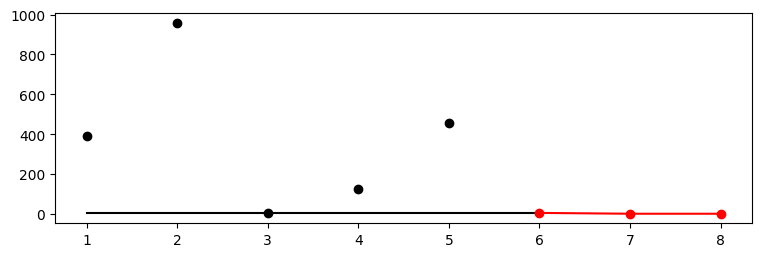

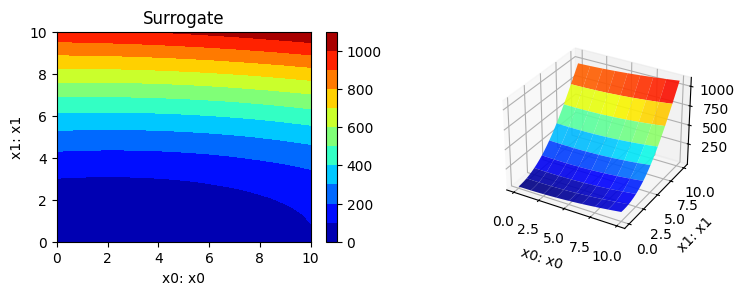

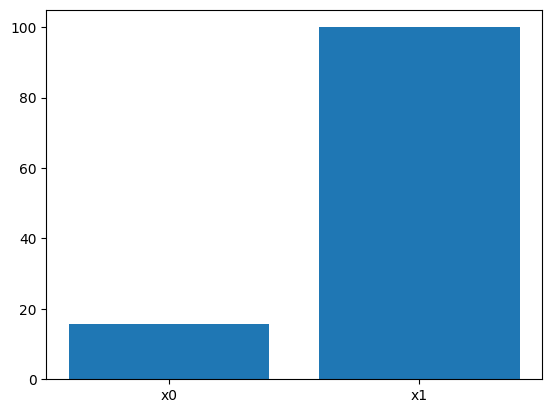

In [23]:
import numpy as np
from math import inf
from spotPython.spot import spot
def objective_function(X, fun_control=None):
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if X.shape[1] != 2:
        raise Exception
    x0 = X[:, 0]
    x1 = X[:, 1]
    y = x0**2 + 10*x1**2
    return y
lower = np.array([0, 0])
upper = np.array([10, 10])
spot = spot.Spot(fun=objective_function,
            lower=lower,
            upper=upper,
            fun_evals=8,
            fun_repeats=1,
            max_time=inf,
            noise=False,
            tolerance_x=0,
            ocba_delta=0,
            var_type=["num", "num"],
            infill_criterion="ei",
            n_points=1,
            seed=123,
            log_level=20,
            show_models=False,
            show_progress=True,
            design_control={"init_size": 5, "repeats": 1},
            surrogate_control={"model_fun_evals": 1000,
                               "min_theta": -3.,
                               "max_theta": 3.,
                               "n_theta": 2,
                               "theta_init_zero": True,
                               "n_p": 1,
                               "optim_p": False,
                               "var_type": ["num", "num"],
                               "seed": 124,},
            optimizer_control={"max_iter": 1000})
spot.run()
spot.plot_progress()
spot.plot_contour(i=0, j=1)
spot.plot_importance()